In [7]:
import os, sys
import caffe
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format
import urllib, cStringIO
from cStringIO import StringIO

def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']

def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

def showarray(a, fmt='png'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def loadImageFromUrlOrLocalPath(pathOrUrl, maxSideLength = 1024, previewImage = False ):
    if 'http' in pathOrUrl:
        file = cStringIO.StringIO(urllib.urlopen(pathOrUrl).read())
        png = PIL.Image.open(file)
    else: 
        png = PIL.Image.open(pathOrUrl)
    s = png.size
    if ( np.max(s) > maxSideLength ):
        ratio = float(maxSideLength)/float(np.max(s))
        png = png.resize([int(s[0]*ratio), int(s[1]*ratio)], PIL.Image.ANTIALIAS)
    
    if png.mode == 'RGBA':
        src = PIL.Image.new("RGB", png.size, (255, 255, 255))
        src.paste(png, mask=png.split()[3])
    else:
        src = png
        
    img = np.float32(src)
    if previewImage is True:
        showarray(img)
        
    return img

In [8]:
model_path = '/home/paperspace/Desktop/model/bvlc_googlenet/'
net_fn = model_path + 'deploy.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'

mean = np.float32([104.0, 117.0, 123.0]) 
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True

open('tmp.prototxt', 'w').write(str(model))
net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = mean,
                       channel_swap = (2,1,0)) 


In [9]:
def deepdream(net, base_img, 
              octave_n=4, start_size=224,
              iter_list=[100,30,10,10],
              start_jitter=32., end_jitter=16.,
              start_step_size=3., end_step_size=1.5, step_list = None,
              visualize=True,
              start_saturation = 0.0, end_saturation = 0.0, 
              invert = False, recalculateKeepEachOctave = False,
              keep = 2, dropTop=0, keepFactor = 1.0, 
              gamma = 1.0, suppressFactor = 0.0,
              layers=None, keepIndices = None, 
              blurSteps = 0,maximumRadius = 0,
              end='inception_4c/output',
              clip=True, **step_params):    
    
    octaves = [preprocess(net, base_img)]
    octave_scale = pow(float(start_size) / float(np.min(base_img.shape[-3:2])), 1.0 / float(octave_n-1) )
    
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, octave_scale,octave_scale), order=1))
     
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) 
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=4)
                
        layer = end
        if layers:
            layer = layers[octave % len(layers)]

        src.reshape(1,3,h,w) 
        src.data[0] = octave_base+detail
        iter_n = iter_list[octave%len(iter_list)]
        saturation = start_saturation + ((end_saturation - start_saturation) * octave) / octave_n
        jitter = start_jitter + ((end_jitter - start_jitter) * octave) / octave_n
        if step_list is None:
            step_size = start_step_size + ((end_step_size - start_step_size) * octave) / octave_n
        else:
            step_size = step_list[octave%len(step_list)]
            
        for i in xrange(iter_n):
            
            
            keepIndices = make_step(net, end=layer, clip=clip, jitter=jitter, 
                      step_size=step_size, saturation=saturation,
                      keepFactor = keepFactor, gamma = gamma,
                      keep = keep, dropTop = dropTop, invert = invert,
                      suppressFactor = suppressFactor,
                      keepIndices = keepIndices, blurSteps=blurSteps,maximumRadius=maximumRadius,
                       **step_params)
            if recalculateKeepEachOctave is True:
                keepIndices = None
            
            if i is 2 and math.isnan(vis.mean()):
                clear_output(wait=True)
                return deprocess(net, src.data[0]),keepIndices
            
            if visualize:
                vis = deprocess(net, src.data[0])
                if not clip: 
                    vis = vis*(255.0/np.percentile(vis, 99.98))
                showarray(vis)
            
            print "size",h,"x",w
            print "saturation",saturation
            print "octave",octave,"/",octave_n," iteration",i,"/",iter_n
            print 'jitter', jitter
            print 'step_size', step_size
            clear_output(wait=True)
        
        
        detail = src.data[0]-octave_base
        
    return deprocess(net, src.data[0]),keepIndices

In [10]:
def make_step(net, step_size=1.5, end='inception_4c/output', jitter=32, 
              clip=True, saturation = 0.0, invert = False,
              dropTop = 0, keep = 1, keepFactor = 1.0, blurSteps = 0, maximumRadius = 0,
              gamma = 4.0, suppressFactor = 0.000001,
              keepIndices = None ):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] 
    dst = net.blobs[end]
    
    # apply jitter shift
    ox, oy = np.random.randint(-jitter, jitter+1, 2) 
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2)
    
    net.forward(end=end)
   
   
    cnv1 = np.array([[.006, .061, 0.242, 0.383, 0.242, 0.61, .006]])
    cnv2 = np.array([[.006], [.061], [0.242], [0.383], [0.242], [0.61], [.006]])
    '''
    for i in range( len(dst.data[0])):
        for j in range(5):
            dst.data[0][i] = nd.convolve(nd.convolve(dst.data[0][i], cnv1, mode='wrap'), cnv2, mode='wrap')
    '''
    if maximumRadius > 0:
        for i in range( len(dst.data[0])):
            dst.data[0][i] = nd.filters.maximum_filter(dst.data[0][i],size=maximumRadius)
    
    if blurSteps > 0:
        for i in range( len(dst.data[0])):
            for j in range(blurSteps):
                dst.data[0][i] = nd.convolve(nd.convolve(dst.data[0][i], cnv1, mode='nearest'), cnv2, mode='nearest')
            
    v = []
    if (keepIndices is None):
        for i in range( 0, len(dst.data[0])):
            v.append( np.sum(dst.data[0][i]))
        keepIndices = np.array(np.argpartition(v, -(keep+dropTop))[-(keep+dropTop):][:keep])
    
    if not (keepIndices is None):
        for i in range( len(dst.data[0])):
            if i in keepIndices:
                dstmax = dst.data[0][i].max() * keepFactor
                if dstmax > 0.0:
                    if invert is True:
                        dst.data[0][i] = pow(1.0-dst.data[0][i]/dstmax,gamma) * dstmax
                    else:
                        dst.data[0][i] = pow(dst.data[0][i]/dstmax,gamma) * dstmax
            else:
                dstmax = dst.data[0][i].max()
                if dstmax > 0.0:
                    dst.data[0][i] *= suppressFactor / dstmax

    else:
        for i in range( len(dst.data[0])):
            dstmax = dst.data[0][i].max()
            if dstmax > 0 and gamma != 1.0:
                if invert is True:
                    dst.data[0][i] = pow(1.0-dst.data[0][i]/dstmax,gamma) * dstmax
                else:
                    dst.data[0][i] = pow(dst.data[0][i]/dstmax,gamma) * dstmax
    
   

    dst.diff[:] = dst.data  
    net.backward(start=end)
    g = src.diff[0]
    
    src.data[:] += step_size/np.abs(g).mean() * g 
    src.data[0] +=  (src.data[0] - src.data[0].mean( axis=0)) * saturation 
    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) 
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)
    
    return keepIndices


In [11]:
for end in net.blobs.keys():
    cur = net.blobs[end]
    print end + ': {}x{}x{}'.format(cur.channels, cur.width, cur.height)

data: 3x224x224
conv1/7x7_s2: 64x112x112
pool1/3x3_s2: 64x56x56
pool1/norm1: 64x56x56
conv2/3x3_reduce: 64x56x56
conv2/3x3: 192x56x56
conv2/norm2: 192x56x56
pool2/3x3_s2: 192x28x28
pool2/3x3_s2_pool2/3x3_s2_0_split_0: 192x28x28
pool2/3x3_s2_pool2/3x3_s2_0_split_1: 192x28x28
pool2/3x3_s2_pool2/3x3_s2_0_split_2: 192x28x28
pool2/3x3_s2_pool2/3x3_s2_0_split_3: 192x28x28
inception_3a/1x1: 64x28x28
inception_3a/3x3_reduce: 96x28x28
inception_3a/3x3: 128x28x28
inception_3a/5x5_reduce: 16x28x28
inception_3a/5x5: 32x28x28
inception_3a/pool: 192x28x28
inception_3a/pool_proj: 32x28x28
inception_3a/output: 256x28x28
inception_3a/output_inception_3a/output_0_split_0: 256x28x28
inception_3a/output_inception_3a/output_0_split_1: 256x28x28
inception_3a/output_inception_3a/output_0_split_2: 256x28x28
inception_3a/output_inception_3a/output_0_split_3: 256x28x28
inception_3b/1x1: 128x28x28
inception_3b/3x3_reduce: 128x28x28
inception_3b/3x3: 192x28x28
inception_3b/5x5_reduce: 32x28x28
inception_3b/5x5: 9

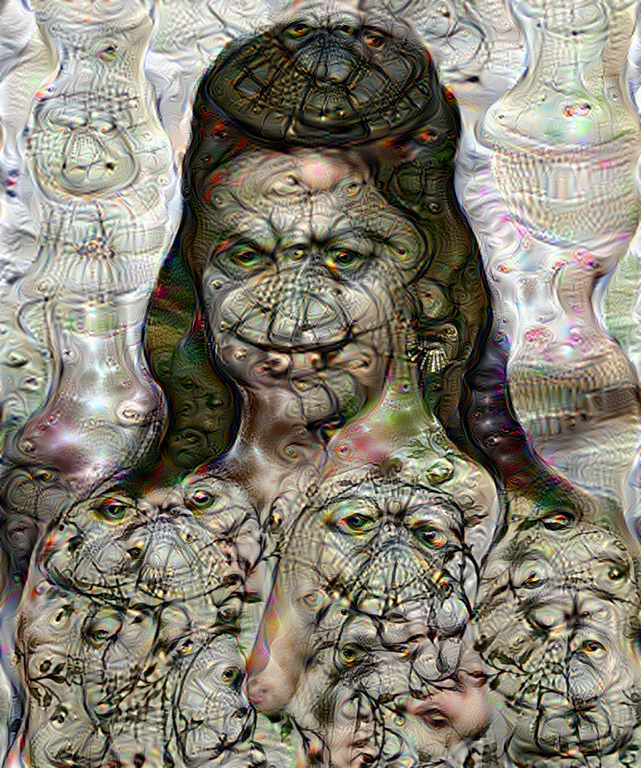

528 channels in inception_4d/output
channels used: [ 34  22 403  11]
[ 2.3829847   1.64862262  1.14056819  0.7890804   0.54591026  0.37767762]


In [16]:
import math
caffe.set_device(0)
caffe.set_mode_gpu()

img = loadImageFromUrlOrLocalPath('/home/paperspace/Desktop/deepi.jpg')

end = 'inception_4d/output'

np.random.seed(seed=42)

firstOctaveImageSize = 200
octaveSteps = 6

iterationsPerOctave = [int(i) for i in np.logspace(1.9, 1.4, num=octaveSteps)]

stepSizePerOctave = np.logspace(1.9, 1.1, num=octaveSteps) * 0.03

frame,keepIndices = deepdream(net, img, 
          iter_list = iterationsPerOctave,
          start_jitter=60., end_jitter=2.,
          step_list = stepSizePerOctave, 
          recalculateKeepEachOctave = False, 
          start_saturation = -0.01, end_saturation = 0.00, 
          invert = False, 
          keepIndices = None, 
          keep = 4, dropTop = 50, 
          keepFactor = 1.0, 
          suppressFactor = 0.00000,
          gamma = 1.0, 
          octave_n = octaveSteps, 
          start_size = firstOctaveImageSize,
          blurSteps = 0, 
          maximumRadius = 0, 
          visualize=True,
          end=end)

showarray(frame)
print net.blobs[end].channels,"channels in",end
print "channels used:",keepIndices
print stepSizePerOctave